In [1]:
# import required libraries
%pylab inline
import io
import os
import csv

from sklearn.metrics import accuracy_score

from livelossplot import PlotLosses
from pycm import *
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import TensorDataset, DataLoader, random_split

Populating the interactive namespace from numpy and matplotlib


In [2]:
# setting up cuda if availble
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [3]:
# path to directory with train and test folder defined by user
path = './data/'

In [4]:
def set_seed(seed):
    """
    This function is used to set all the random seeds to a fixed value and take out any randomness from cuda kernels.

    Args:
        seed: An integer repersenting a fixed random seed.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

class CustomImageFolder(ImageFolder):
    """
    Custom ImageFolder class to store individual path and name of test image files in tuple. 
    Used only on the test data set to create the .csv file containing the name of test image files 
    and their predicted labels.
    
    Args:
        ImageFolder: A dataloader from the pytorch library to load images.
    """
    def __getitem__(self, index):
        
        # the original tuple created by pytorch ImageFolder function
        original_tuple = super(CustomImageFolder, self).__getitem__(index)
        
        # path of the test imags
        path = self.imgs[index][0]
        
        # adding the path of test images to a tuple
        new_tuple = (original_tuple + (path,))
        
        return new_tuple

In [5]:
# means and stds of the full training data set (pre-calculated) in each channel (total of 3 channels as RGB)
# this is used to perform Z-normalization on the full training set
# The means and stds are from the pre-trained model of ResNet50 from the pytorch library
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

# list of transforms to perform on the entire training set - the order matters
# 1. resize the PIL image from 64 to 224 as pretrained ResNet50 takes in images of size 224 with .Resize()
# 2. convert the PIL images into torch tensors using .ToTensor()
# 3. normalize every pixel per channel using .Normalize()
# can also add data augumentation transforms, but found that this reduced accuracy
train_normalise = transforms.Compose([
                    transforms.Resize(224),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=np.array(means), std=np.array(stds))])

# list of transforms to perform on the entire test set - same as for training set but without data augumentation (if added before)
test_normalise = transforms.Compose([
                    transforms.Resize(224),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=np.array(means), std=np.array(stds))])

# load training and test images with ImageFolder and CustomImageFolder respectively, and apply defined transforms
full_data = ImageFolder(path+'train', transform=train_normalise)
test_data_raw = CustomImageFolder(path+'test', transform=test_normalise)

In [6]:
# setting up the train and validation split (80 training:20 validation)
train_size = int(0.8 * len(full_data))
validation_size = len(full_data) - train_size

# randomly split a dataset into non-overlapping new datasets of given the lengths
# uses less RAM then StratifiedShuffleSplit 
train_dataset, validation_dataset = random_split(full_data, [train_size, validation_size])

# storing test data in an array
test_dataset = np.array([v[0].numpy() for v in test_data_raw])

# batch size for training, validation and test
batch_size = 128
test_batch_size = 500

# setting up dataloaders for training, validation and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

In [7]:
# function to optimize and train the model
def train(model, optimizer, criterion, data_loader):
    """
    Function to train a model on a training dataset.
    
    Args:
        model: The model to be trained.
        optimizer: Iterative method to reduce the loss function.
        criterion: The way in which the loss function is calculated.
        data_loader: Subsamples over the training dataset. 
    
    """
    model.train()
    train_loss, train_accuracy = 0, 0
    i = 0
    for X, y in data_loader:
        i += 1
        if i % 100 == 0:
            print(i)
            
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 3, 224, 224)) #modification described above
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

# function to validate training model with validation dataset
def validate(model, criterion, data_loader):
    """
       Function that calculates the accuracy and log loss using a validation dataset.
    
    Args:
        model: A trained model. 
        criterion: The way in which the loss function is calculated.
        data_loader: Subsamples over the validation dataset. 
    
    """
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    
    for X, y in data_loader:
        with torch.no_grad():
            
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 224, 224)) #modification described above
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

# function to evaluate model without plots using testing or validation datasets
def evaluate(model, data_loader):
    """
        Function to create a prediction based on test images using a trained model.
        Output will be the np.array of predicted labels.
    
    Args:
        model: The trained model.
        data_loader: Subsamples over the test dataset. 
    
    """
    model.eval()
    y_preds = []
    for X in data_loader:
        with torch.no_grad():
            
            X = X.to(device)
            a2 = model(X.view(-1, 3, 224 , 224))                                                          
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0)

In [8]:
# import pre-trained model from pytorch
# ResNet-50 model from "Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`
resnet50 = models.resnet50(pretrained=True, progress=True)

def set_parameter_requires_grad(model):
    """
    Function to set the gradient requirement of the parameters to pre-trained model to False.
    This thuerefore allows us to do feature extraction.
    
    Args:
    model: imported pre-trained classifier model from pytorch library.
        
    """
    for param in model.parameters():
        param.requires_grad = False

        
#function to initialize imported model
def initialize_model(num_classes, use_pretrained=True):
    """
    Function to initialise Pre-trained ResNet50 model.
    The pre-trained parameters improves the overall accuracy of the model.
    The method used was feature extraction.
    
        Args:
        num_classes: Set to 200 globally.
        Use_pretrained: A bool. Default using pre-trained model. 
        
    """
    set_parameter_requires_grad(resnet50)
    fc_inputs = resnet50.fc.in_features
    resnet50.fc = nn.Sequential(
        nn.Linear(fc_inputs, num_classes))
    
    return resnet50

#set the number of output classes
num_classes = 200 
resnet50 = initialize_model(num_classes, use_pretrained=True)

# Send the model to GPU
resnet50 = resnet50.to(device)

#the parameters to be optimized
params_to_update = resnet50.parameters()

In [9]:
# hyperparameters
seed = 42
lr = 2e-3
momentum = 0.9
batch_size = 128
test_batch_size = 500
n_epochs = 10
weight_decay = 1e-2

In [10]:
# setup defined randomness
set_seed(seed)

# initialize optimizer
optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=momentum)

# define loss function to be used for training
criterion = nn.CrossEntropyLoss()

In [11]:
# main training loop function for training and validation sets
def train_pret_model(momentum):
    """
    Function to train model on the train and validation dataset.
    
    Args:
        momentum: momentum parameter of the SGD optimizer. 
    
    """
    liveloss = PlotLosses()
    for epoch in range(n_epochs):
        logs = {}
        train_loss, train_accuracy = train(resnet50, optimizer_ft, criterion, train_loader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss, validation_accuracy = validate(resnet50, criterion, validation_loader)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()
        torch.save(resnet50.state_dict(), "./val_train2_e%s.pth" % epoch)

    return resnet50

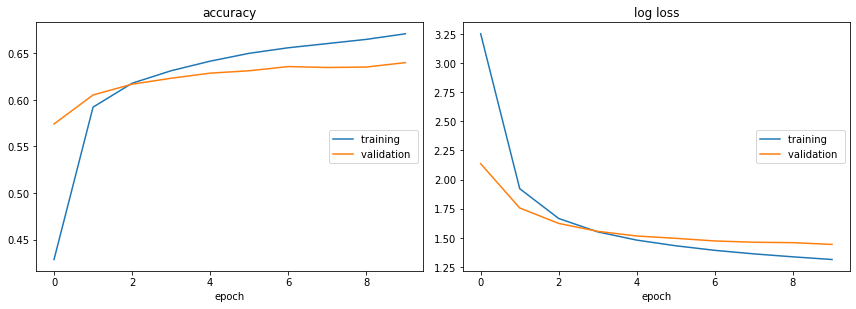

accuracy
	training         	 (min:    0.429, max:    0.671, cur:    0.671)
	validation       	 (min:    0.574, max:    0.640, cur:    0.640)
log loss
	training         	 (min:    1.314, max:    3.251, cur:    1.314)
	validation       	 (min:    1.444, max:    2.136, cur:    1.444)


In [11]:
# train and validate
model = train_pret_model(momentum)

In [13]:
# reinitializing the model import for full training set
# ResNet-50 model from "Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`
resnet50 = models.resnet50(pretrained=True, progress=True)

def set_parameter_requires_grad(model):
    """
    Function to set the gradient requirement of the parameters to pre-trained model to False.
    
    Args:
    model: imported pre-trained classifier model from pytorch library.
        
    """
    for param in model.parameters():
        param.requires_grad = False


#function to initialize imported model
def initialize_model(num_classes, use_pretrained=True):
    """
    Function to initialise Pre-trained ResNet50 model.
    The pre-trained parameters improves the overall accuracy of the model at low epochs.
    The method used was feature extraction.

        Args:
        num_classes: Set to 200 globally.
        Use_pretrained: A bool. Default using pre-trained model. 
        
    """
    set_parameter_requires_grad(resnet50)
    fc_inputs = resnet50.fc.in_features
    resnet50.fc = nn.Sequential(
        nn.Linear(fc_inputs, num_classes))
    
    return resnet50

#set the number of output classes
num_classes = 200 
resnet50 = initialize_model(num_classes, use_pretrained=True)

# Send the model to GPU
resnet50 = resnet50.to(device)

#the parameters to be optimized
params_to_update = resnet50.parameters()

# setup defined randomness
set_seed(seed)

# initialize optimizer
optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=momentum)

# define loss function to be used for training
criterion = nn.CrossEntropyLoss()

In [14]:
# reset training dataloader for the full training set
train_loader = DataLoader(full_data, batch_size=batch_size, shuffle=True, num_workers=0)

# main training loop function for full training set
def full_train(momentum):
    """
    Function to train model on the whole training dataset.
    
    Args:
        momentum: momentum parameter of the SGD optimizer. 
    
    """
    liveloss = PlotLosses()
    for epoch in range(10):
        logs = {}
        train_loss, train_accuracy = train(resnet50, optimizer_ft, criterion, train_loader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()
        torch.save(resnet50.state_dict(), "./full_train2_e%s.pth" % epoch)
    return resnet50

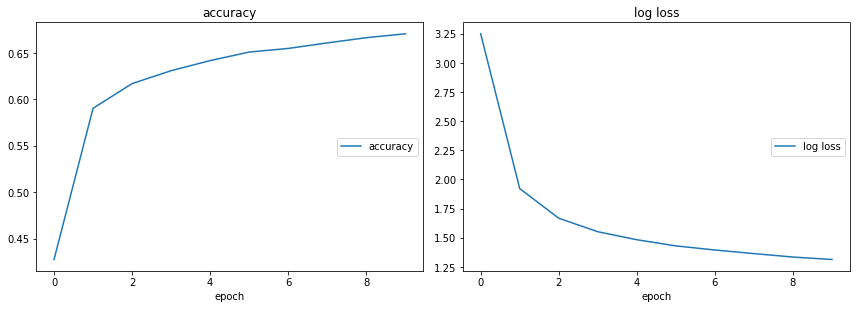

accuracy
	accuracy         	 (min:    0.427, max:    0.671, cur:    0.671)
log loss
	log loss         	 (min:    1.313, max:    3.250, cur:    1.313)


In [14]:
# full training
model = full_train(momentum)

In [18]:
# get predicted class using trained model
y_pred = evaluate(model, test_loader)

In [15]:
# function to write results of predicted class into csv format
# path_to_test should be defined by user to direct to where the test images folder is
# exmaple: path_to_test = './data/test/images/'
# note: the "/" at the end of path is required
path_to_test = './data/test/images/'
path_len = len(path_to_test)

def write_csv(csv_name):
    """
    Function to output filename and predicted label of test images into csv format.
    First column is the filename, second column is the label in integer of the 200 classes.
    Headers are included as "Filename" and "Label"
    
    Args:
        csv_name: desired name of the output csv file. 
    
    """
    with open(csv_name, 'w', newline='') as newFile:
        
        writer = csv.writer(newFile, lineterminator='\n')
        writer.writerow(("Filename","Label"))
        i = 0 
        for y in y_pred:
            writer.writerow((test_data_raw[i][2][path_len:-4] + 'jpeg', y.astype("U")))
            i += 1        

    return 0

In [26]:
# defining the name of desired csv file then call function
csv_name = 'full22.csv'
write_csv(csv_name)

0

In [16]:
# function to print out the content of created csv file from function write_csv(csv_name) to double check format
def print_csv(csv_name):
    """
    Function to print out and test the csv file output is in the right format.
    
    Args:
        csv_name: the csv file name to be read and tested. 
    
    """
    with open(csv_name) as csv_file:
        
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            print(row)
            
    return 0

In [28]:
# call function and print the csv file generated
print_csv(csv_name)

['Filename', 'Label']
['test_0.jpeg', '111']
['test_1.jpeg', '84']
['test_10.jpeg', '53']
['test_100.jpeg', '90']
['test_1000.jpeg', '138']
['test_1001.jpeg', '138']
['test_1002.jpeg', '135']
['test_1003.jpeg', '197']
['test_1004.jpeg', '45']
['test_1005.jpeg', '88']
['test_1006.jpeg', '63']
['test_1007.jpeg', '107']
['test_1008.jpeg', '9']
['test_1009.jpeg', '11']
['test_101.jpeg', '42']
['test_1010.jpeg', '51']
['test_1011.jpeg', '23']
['test_1012.jpeg', '167']
['test_1013.jpeg', '78']
['test_1014.jpeg', '195']
['test_1015.jpeg', '63']
['test_1016.jpeg', '162']
['test_1017.jpeg', '27']
['test_1018.jpeg', '170']
['test_1019.jpeg', '194']
['test_102.jpeg', '45']
['test_1020.jpeg', '71']
['test_1021.jpeg', '35']
['test_1022.jpeg', '69']
['test_1023.jpeg', '51']
['test_1024.jpeg', '83']
['test_1025.jpeg', '104']
['test_1026.jpeg', '182']
['test_1027.jpeg', '35']
['test_1028.jpeg', '113']
['test_1029.jpeg', '80']
['test_103.jpeg', '130']
['test_1030.jpeg', '136']
['test_1031.jpeg', '10']


['test_289.jpeg', '190']
['test_2890.jpeg', '25']
['test_2891.jpeg', '198']
['test_2892.jpeg', '59']
['test_2893.jpeg', '1']
['test_2894.jpeg', '74']
['test_2895.jpeg', '123']
['test_2896.jpeg', '176']
['test_2897.jpeg', '104']
['test_2898.jpeg', '164']
['test_2899.jpeg', '118']
['test_29.jpeg', '25']
['test_290.jpeg', '134']
['test_2900.jpeg', '36']
['test_2901.jpeg', '82']
['test_2902.jpeg', '141']
['test_2903.jpeg', '109']
['test_2904.jpeg', '186']
['test_2905.jpeg', '150']
['test_2906.jpeg', '41']
['test_2907.jpeg', '174']
['test_2908.jpeg', '157']
['test_2909.jpeg', '71']
['test_291.jpeg', '165']
['test_2910.jpeg', '136']
['test_2911.jpeg', '182']
['test_2912.jpeg', '47']
['test_2913.jpeg', '34']
['test_2914.jpeg', '18']
['test_2915.jpeg', '169']
['test_2916.jpeg', '195']
['test_2917.jpeg', '177']
['test_2918.jpeg', '59']
['test_2919.jpeg', '182']
['test_292.jpeg', '136']
['test_2920.jpeg', '1']
['test_2921.jpeg', '144']
['test_2922.jpeg', '151']
['test_2923.jpeg', '167']
['test_2

['test_4848.jpeg', '73']
['test_4849.jpeg', '183']
['test_485.jpeg', '165']
['test_4850.jpeg', '151']
['test_4851.jpeg', '5']
['test_4852.jpeg', '190']
['test_4853.jpeg', '79']
['test_4854.jpeg', '138']
['test_4855.jpeg', '77']
['test_4856.jpeg', '22']
['test_4857.jpeg', '142']
['test_4858.jpeg', '167']
['test_4859.jpeg', '144']
['test_486.jpeg', '96']
['test_4860.jpeg', '91']
['test_4861.jpeg', '1']
['test_4862.jpeg', '194']
['test_4863.jpeg', '41']
['test_4864.jpeg', '44']
['test_4865.jpeg', '76']
['test_4866.jpeg', '41']
['test_4867.jpeg', '48']
['test_4868.jpeg', '47']
['test_4869.jpeg', '178']
['test_487.jpeg', '25']
['test_4870.jpeg', '45']
['test_4871.jpeg', '4']
['test_4872.jpeg', '140']
['test_4873.jpeg', '63']
['test_4874.jpeg', '140']
['test_4875.jpeg', '98']
['test_4876.jpeg', '13']
['test_4877.jpeg', '15']
['test_4878.jpeg', '157']
['test_4879.jpeg', '144']
['test_488.jpeg', '37']
['test_4880.jpeg', '2']
['test_4881.jpeg', '42']
['test_4882.jpeg', '198']
['test_4883.jpeg',

['test_6673.jpeg', '17']
['test_6674.jpeg', '105']
['test_6675.jpeg', '66']
['test_6676.jpeg', '38']
['test_6677.jpeg', '7']
['test_6678.jpeg', '50']
['test_6679.jpeg', '169']
['test_668.jpeg', '129']
['test_6680.jpeg', '58']
['test_6681.jpeg', '73']
['test_6682.jpeg', '89']
['test_6683.jpeg', '77']
['test_6684.jpeg', '117']
['test_6685.jpeg', '143']
['test_6686.jpeg', '182']
['test_6687.jpeg', '193']
['test_6688.jpeg', '178']
['test_6689.jpeg', '44']
['test_669.jpeg', '78']
['test_6690.jpeg', '65']
['test_6691.jpeg', '199']
['test_6692.jpeg', '170']
['test_6693.jpeg', '123']
['test_6694.jpeg', '155']
['test_6695.jpeg', '150']
['test_6696.jpeg', '78']
['test_6697.jpeg', '160']
['test_6698.jpeg', '93']
['test_6699.jpeg', '156']
['test_67.jpeg', '101']
['test_670.jpeg', '131']
['test_6700.jpeg', '54']
['test_6701.jpeg', '97']
['test_6702.jpeg', '29']
['test_6703.jpeg', '73']
['test_6704.jpeg', '9']
['test_6705.jpeg', '144']
['test_6706.jpeg', '80']
['test_6707.jpeg', '124']
['test_6708.j

['test_8311.jpeg', '161']
['test_8312.jpeg', '140']
['test_8313.jpeg', '2']
['test_8314.jpeg', '88']
['test_8315.jpeg', '177']
['test_8316.jpeg', '64']
['test_8317.jpeg', '103']
['test_8318.jpeg', '96']
['test_8319.jpeg', '83']
['test_832.jpeg', '160']
['test_8320.jpeg', '189']
['test_8321.jpeg', '60']
['test_8322.jpeg', '175']
['test_8323.jpeg', '138']
['test_8324.jpeg', '117']
['test_8325.jpeg', '55']
['test_8326.jpeg', '118']
['test_8327.jpeg', '47']
['test_8328.jpeg', '43']
['test_8329.jpeg', '111']
['test_833.jpeg', '80']
['test_8330.jpeg', '136']
['test_8331.jpeg', '57']
['test_8332.jpeg', '4']
['test_8333.jpeg', '199']
['test_8334.jpeg', '192']
['test_8335.jpeg', '77']
['test_8336.jpeg', '125']
['test_8337.jpeg', '176']
['test_8338.jpeg', '123']
['test_8339.jpeg', '98']
['test_834.jpeg', '96']
['test_8340.jpeg', '11']
['test_8341.jpeg', '34']
['test_8342.jpeg', '98']
['test_8343.jpeg', '136']
['test_8344.jpeg', '9']
['test_8345.jpeg', '161']
['test_8346.jpeg', '181']
['test_8347

0